In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.speedup import calculate_speedups

sns.set_theme()

## Read data

In [2]:
threads = 32

branches = ['master-busy-wait-dynamic',
            'master-busy-wait-dynamic-v2',
            'master-busy-wait-dynamic-sleep',
            'master-busy-wait-dynamic-sleep-clean']

our_df = None
master_df = None

for i in range(1, threads + 1):
    for branch in branches:
        filename = '06-07-2022/100gen/speedup-{}-{}-threads.csv'.format(branch, i)
        new_df = pd.read_csv(filename)
        new_df['threads'] = i
        new_df['branch'] = branch
        our_df = pd.concat([our_df, new_df], ignore_index = True)
        
    filename = '06-07-2022/100gen/speedup-master-{}-threads.csv'.format(i)
    new_master_df = pd.read_csv(filename)
    new_master_df['threads'] = i
    new_master_df['branch'] = 'master'
    master_df = pd.concat([master_df, new_master_df], ignore_index = True)

## Calculate speedups and prepare to plot

In [3]:
speedups_us = calculate_speedups(our_df)
speedups_us_df = pd.DataFrame(data=speedups_us)

speedups_master = calculate_speedups(master_df)
speedups_master_df = pd.DataFrame(data=speedups_master)

df = pd.concat([speedups_us_df, speedups_master_df], ignore_index = True)

## Plot fixed frequency speedups

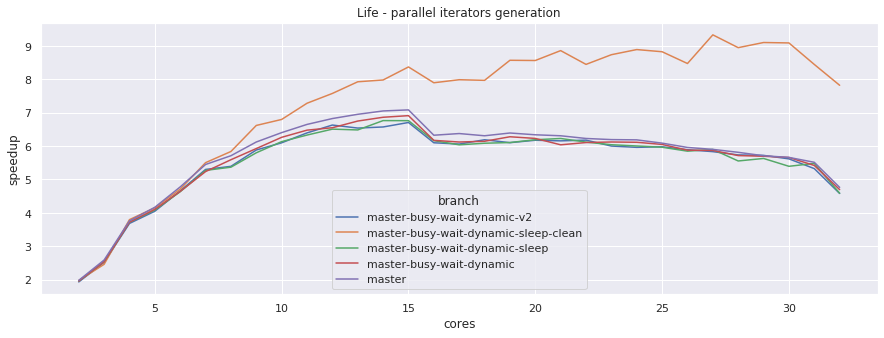

In [4]:
algorithms = set(df['name'])

fig, ax = plt.subplots(len(algorithms), figsize=(15, 5))

for i, algorithm in enumerate(algorithms):
    algorithm_df = df[df['name'] == algorithm]
    
    sns.lineplot(x='cores', y='speedup', hue='branch', data=algorithm_df, ax=ax);
    ax.set_title(algorithm);    

# Branches description

### master

rayon's original scheduler

### master-busy-wait-dynamic

Replaces `thread::yield` by a busy-wait loop whose number of cycles is multiplied by 1.25 after each failed steal attempt until it reaches a threshold of 500 us. After that, we block on a latch.

### master-busy-wait-dynamic-v2:

Same as before, but with a few changes to properly use the `sleepy` state from rayon.

### master-busy-wait-dynamic-sleep:

Uses the same busy-wait logic from `master-busy-wait-dynamic`, but replaces the latch by a `thread::sleep` call. Here, I didn't remove neither the counters nor the heuristics associated to the logic used to wake up the latches. 

### master-busy-wait-dynamic-sleep-clean:

Same as `master-busy-wait-dynamic-sleep`, but with all the counter and logic used to wakeup the latches removed.

## Conclusion

The goal of this experiment was to identify why we get better performance in some algorithms (here the `LifeParIter` was chosen to a deep analysis). To do that, the new proposed algorithm was implemented in cumulative steps, each step in one branch, so that we could test one by one to detect which step was the responsible for the improvements in performance. As for the last experiments, these were also performed on a CPU running at a fixed-frequency (2.1 GHz) with idle states disabled using a number of threads equal to the number of cores (32 in a machine with 32 cores / 2 threads, and not 64).

The only branch that has a significant improvement over the others is `master-busy-wait-dynamic-sleep-clean`, which suggests that our algorithm is faster because it is decentralized and all the existing overhead to wakeup/put threads to sleep doesn't exist anymore, since the threads are self-managed.

The results from today (and the ones from [yesterday](speedup-rayon-busy-wait.ipynb)) show that there isn't a significant improvement when using busy-wait loops instead of `thread::yield`. In fact, `thread::yield` seems to perform slightly better then the loops in all cases, [as seen here](speedup-rayon-busy-wait.ipynb) and it should be more energy efficient (to be verified).

In the other hand, it is known at this point that the sleep-based algorithm causes some CPU governors to decrease the CPU frequency as they see a lot of cores sleeping (the exact cause of that is yet to be further studied). What make us win in a fixed-frequency scenario is also what makes us lose when using the standard CPU governors.

Our hypothesis was that some of the atomic counters used to keep track of the state of threads are being accessed a lot, slowing everything down. To verify that, `perf report`s were performed using different numbers of threads and we expected to see the overhead in atomic operations increasing as the number of threads increases.

The `perf report` of `LifeParIter` running with 4 threads:

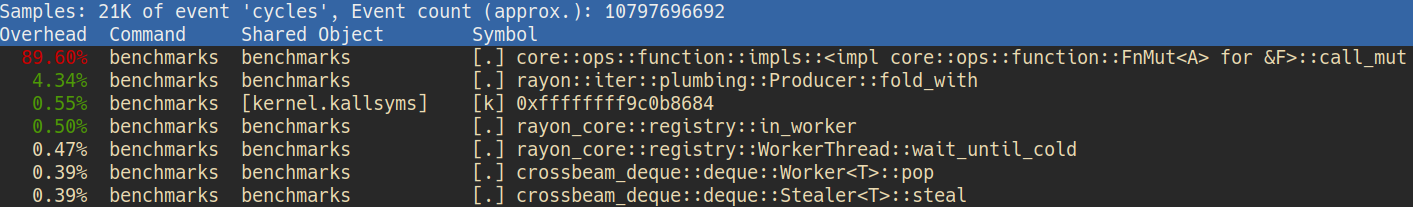

`rayon_core::registry` routines used less than 1% of the total cycles when using 4 threads.

And also with 22 threads:

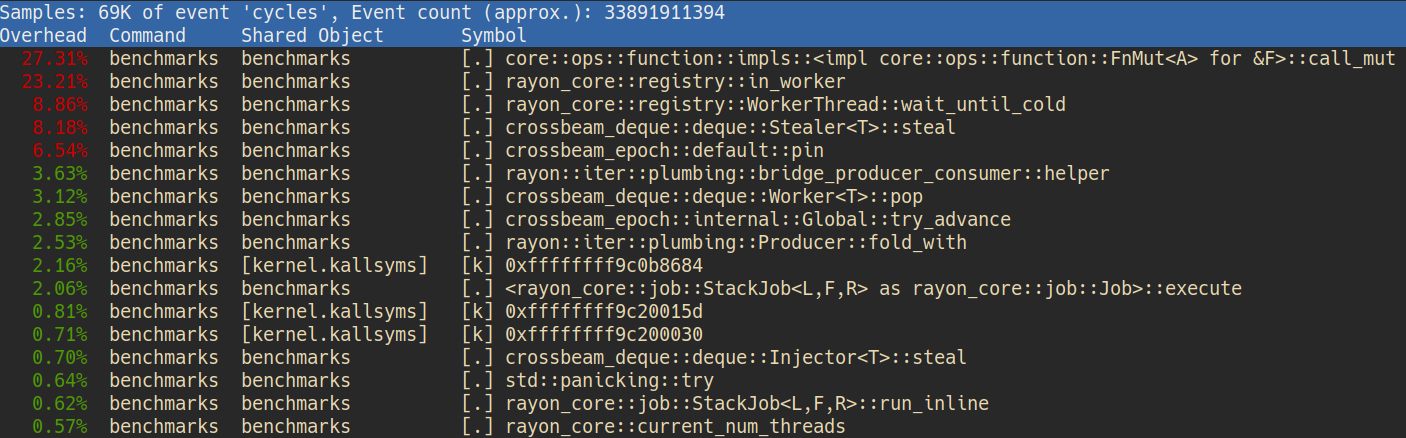

With 22, they used around 32% already.

And finally, 32 threads:

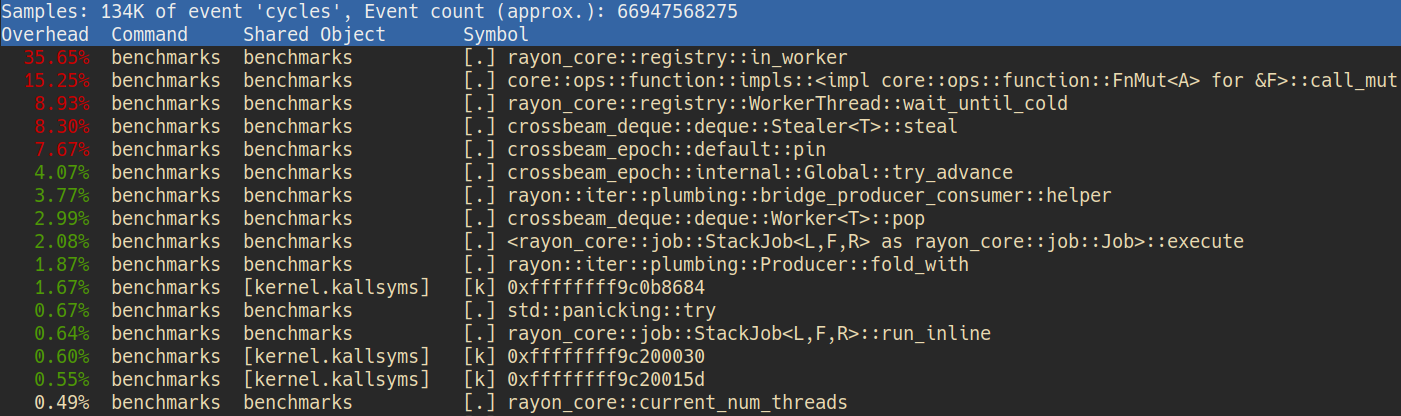

The `rayon_core::registry::in_worker` alone took 35.65 % of the cycles, which is more than what was used to perform the parallel work itself. The number of cycles used by `rayon_core::registry::wait_until_cold` also increased, reaching 8.93 %.

Zooming in `rayon_core::registry::in_worker`:

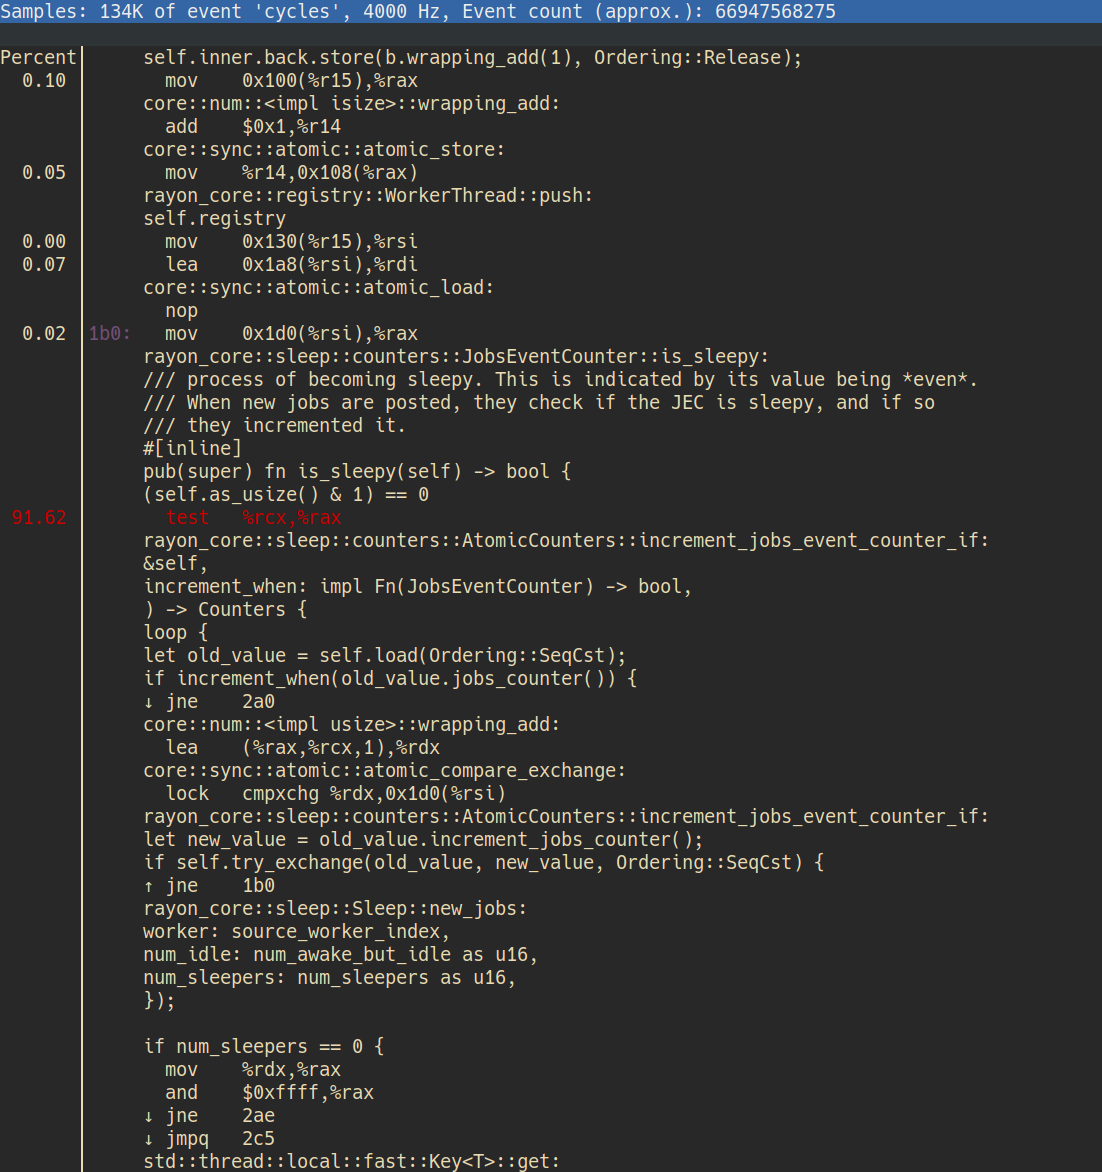

Zooming in `rayon_core::registry::wait_until_cold`

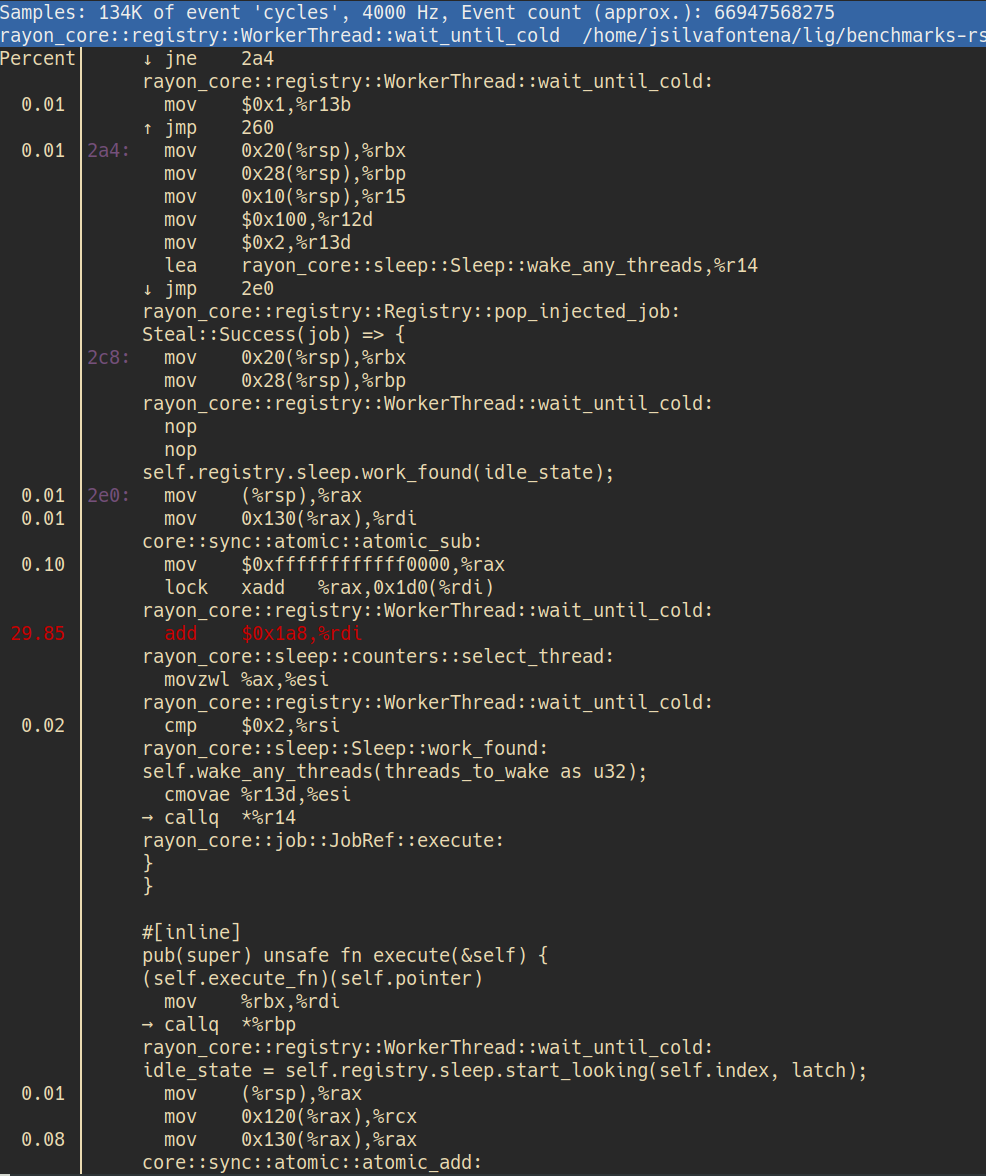

The main problem is caused by the function `JobsEventCounter::is_sleepy`, that is called before changing the value of the `JobsEventCounter` whenever a new job is posted. The second problem is called by an `add` instruction inside `registry::wait_until_cold`. This `add` actually comes from the function `sleep::start_looking` that is inlined inside `wait_until_cold`. The `add` is used to increment the number of inactive threads whenever a thread start looking for jobs.


instead of wait we could wait_timeout? (and maybe remove the sleepy counter)